# SM2 Public Dataset — Data Demography & Quality Template

This notebook provides a **complete, reproducible data demography** for the SM2 public dataset.
It is designed as a **reference template** you can copy for future datasets.

## What you get
- Download & load (Parquet preferred, CSV.GZ fallback)
- Schema & dtypes, memory footprint, basic stats
- Categorical profiles (distinct counts, top values)
- Missingness (by column and by time bins)
- Duplicate detection (key-level and row-level)
- Time coverage & completeness (global, per `source`, `data_key`, `location`)
- Derived fields for `location` (Atrea vs ThermoPro, floor, section)
- Value quality rules (temperature & humidity plausible ranges)
- Simple visualizations (histograms, boxplots, coverage heatmaps)
- Export of summary CSVs (ready for reporting or CI checks)

**Notes**
- Timestamps are **UTC**, hourly granularity by design.
- Temperatures (`temp_*`) are in **°C**; humidity (`humidity_*`) in **%**.
- Plots use **matplotlib** (one plot per figure; no explicit color settings).


In [1]:
# Install (if needed) — in Colab this typically works out-of-the-box
try:
    import pandas as pd
    import matplotlib
except Exception:
    %pip install -q pandas pyarrow matplotlib gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os, re
from datetime import datetime, timezone

plt.rcParams['figure.figsize'] = (12, 6)  # single-figure charts, no explicit colors
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)


## Download data from Google Drive

Parquet is preferred (smaller/faster). CSV.GZ is provided as a fallback.

In [2]:
PARQUET_ID = "1gLPWgUGtRb371Gpv5O8t5j95lthNjELg"  # sm2_public_dataset.parquet
CSVGZ_ID  = "1eLOAOZ13--EKE63GZhmerjmY9zkeJcyd"  # sm2_public_dataset.csv.gz
USE_PARQUET = True

parquet_path = Path("sm2_public_dataset.parquet")
csvgz_path   = Path("sm2_public_dataset.csv.gz")

def gdown_download(file_id: str, out_path: Path):
    """Download a public Google Drive file via gdown."""
    import subprocess, sys
    try:
        import gdown  # type: ignore
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gdown"])  # noqa
        import gdown  # type: ignore
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(out_path), quiet=False)

if USE_PARQUET:
    if not parquet_path.exists():
        print("Downloading Parquet…")
        gdown_download(PARQUET_ID, parquet_path)
else:
    if not csvgz_path.exists():
        print("Downloading CSV.GZ…")
        gdown_download(CSVGZ_ID, csvgz_path)


Downloading...
From: https://drive.google.com/uc?id=1gLPWgUGtRb371Gpv5O8t5j95lthNjELg
To: /content/sm2_public_dataset.parquet
100%|██████████| 1.29M/1.29M [00:00<00:00, 103MB/s]


## Load dataset

In [3]:
if USE_PARQUET and parquet_path.exists():
    df = pd.read_parquet(parquet_path)
elif csvgz_path.exists():
    df = pd.read_csv(csvgz_path, compression="gzip")
else:
    raise FileNotFoundError("Dataset not found. Check IDs or internet access.")

# Basic typing
df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
df['data_value'] = pd.to_numeric(df['data_value'], errors='coerce')

print("Shape:", df.shape)
df.head(3)


Shape: (651332, 6)


,time,location,source,measurement,data_key,data_value
0,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_ambient,4.0
1,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_fresh,20.3
2,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_indoor,21.4


## Schema & dtypes

In [4]:
def mem_mb(series: pd.Series) -> float:
    return float(series.memory_usage(deep=True)) / (1024*1024)

schema = (
    pd.DataFrame({
        'column': df.columns,
        'dtype': [str(df[c].dtype) for c in df.columns],
        'non_null': [int(df[c].notna().sum()) for c in df.columns],
        'nulls': [int(df[c].isna().sum()) for c in df.columns],
        'distinct': [int(df[c].nunique(dropna=True)) for c in df.columns],
        'mem_MB': [round(mem_mb(df[c]), 3) for c in df.columns],
    })
    .sort_values(['mem_MB','distinct'], ascending=[False, False])
)
schema


,column,dtype,non_null,nulls,distinct,mem_MB
3,measurement,object,651332,0,1,37.270
4,data_key,object,651332,0,6,37.132
1,location,object,651332,0,36,34.164
2,source,object,651332,0,2,33.624
0,time,"datetime64[ns, UTC]",651332,0,15401,4.969
5,data_value,float64,651332,0,9509,4.969


In [ ]:
schema.to_csv(OUT_DIR / 'schema_overview.csv', index=False)
print("Saved:", OUT_DIR / 'schema_overview.csv')


## Categorical profiles
Top values and distinct counts for key categorical columns.

In [5]:
categoricals = ['source','measurement','data_key','location']
profiles = []
for col in categoricals:
    vc = df[col].value_counts(dropna=False).head(20)
    top_df = vc.reset_index()
    top_df.columns = [col, 'rows']
    top_df.insert(1, 'distinct_total', df[col].nunique(dropna=True))
    top_df.insert(2, 'nulls', int(df[col].isna().sum()))
    top_df['share_%'] = (100.0 * top_df['rows'] / len(df)).round(3)
    profiles.append((col, top_df))
    print(f"\n=== {col} (distinct={df[col].nunique(dropna=True)}, nulls={df[col].isna().sum()}) ===")
    display(top_df)

# Save profiles
for col, tdf in profiles:
    tdf.to_csv(OUT_DIR / f'top_values_{col}.csv', index=False)
print("Saved top value profiles → outputs/top_values_*.csv")



=== source (distinct=2, nulls=0) ===


,source,distinct_total,nulls,rows,share_%
0,Atrea,2,0,630072,96.736
1,ThermoPro,2,0,21260,3.264



=== measurement (distinct=1, nulls=0) ===


,measurement,distinct_total,nulls,rows,share_%
0,nonadditive,1,0,651332,100.0



=== data_key (distinct=6, nulls=0) ===


,data_key,distinct_total,nulls,rows,share_%
0,temp_indoor,6,0,146854,22.547
1,temp_fresh,6,0,136224,20.915
2,temp_waste,6,0,136224,20.915
3,temp_intake,6,0,136224,20.915
4,temp_ambient,6,0,85176,13.077
5,humidity_indoor,6,0,10630,1.632



=== location (distinct=36, nulls=0) ===


,location,distinct_total,nulls,rows,share_%
0,sm2_01,36,0,75680,11.619
1,sm2_02,36,0,69299,10.640
2,sm2_03,36,0,69299,10.640
3,sm2_04,36,0,69299,10.640
4,sm2_05,36,0,69299,10.640
5,sm2_06,36,0,69299,10.640
6,sm2_07,36,0,69299,10.640
7,sm2_08,36,0,69299,10.640
8,sm2_09,36,0,69299,10.640
9,1PP-S1,36,0,4578,0.703


Saved top value profiles → outputs/top_values_*.csv


## Derived fields: Atrea vs ThermoPro, floor & section

- Atrea locations are section-aggregated: `sm2_01 … sm2_09`.
- ThermoPro locations are floor/section: e.g., `1NP-S7`, `2PP-S1`.


In [6]:
def parse_location(loc: str):
    if isinstance(loc, str) and loc.startswith('sm2_'):
        try:
            sec_num = int(loc.split('_')[-1])
        except Exception:
            sec_num = None
        return {'is_atrea': True, 'floor_code': None, 'section_num': sec_num}
    m = re.match(r"^(?P<floor>\d[NP]P?)-S(?P<section>\d+)$", str(loc))
    if m:
        return {'is_atrea': False,
                'floor_code': m.group('floor'),
                'section_num': int(m.group('section'))}
    return {'is_atrea': None, 'floor_code': None, 'section_num': None}

loc_meta = df['location'].drop_duplicates().to_frame()
loc_meta = pd.concat([loc_meta, loc_meta['location'].map(parse_location).apply(pd.Series)], axis=1)
display(loc_meta.sort_values(['is_atrea','floor_code','section_num']).head(20))
loc_meta.to_csv(OUT_DIR / 'location_metadata.csv', index=False)
print("Saved:", OUT_DIR / 'location_metadata.csv')


,location,is_atrea,floor_code,section_num
647872,1NP-S1,False,1NP,1
647874,1NP-S2,False,1NP,2
647876,1NP-S3,False,1NP,3
647826,1NP-S4,False,1NP,4
647828,1NP-S5,False,1NP,5
647830,1NP-S6,False,1NP,6
647832,1NP-S7,False,1NP,7
647834,1NP-S8,False,1NP,8
647836,1NP-S9,False,1NP,9
551373,1PP-S1,False,1PP,1


Saved: outputs/location_metadata.csv


## Time coverage & completeness

We check global coverage, per `source`, per `data_key`, and per `location`.
We also estimate **hourly completeness** within min/max time per group.

In [7]:
def coverage(frame: pd.DataFrame, group_cols):
    g = (frame.groupby(group_cols)
               .agg(start=('time','min'), end=('time','max'), rows=('time','count'))
               .reset_index())
    g['days'] = (g['end'] - g['start']).dt.total_seconds() / 86400.0
    return g.sort_values('rows', ascending=False)

cov_source = coverage(df, ['source'])
cov_source_key = coverage(df, ['source','data_key'])
cov_location = coverage(df, ['location'])
display(cov_source.head(10))
display(cov_source_key.head(20))
display(cov_location.head(20))

cov_source.to_csv(OUT_DIR / 'coverage_by_source.csv', index=False)
cov_source_key.to_csv(OUT_DIR / 'coverage_by_source_data_key.csv', index=False)
cov_location.to_csv(OUT_DIR / 'coverage_by_location.csv', index=False)
print("Saved coverage CSVs in outputs/")


,source,start,end,rows,days
0,Atrea,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,630072,631.125000
1,ThermoPro,2025-05-26 01:00:00+00:00,2025-09-02 16:34:00+00:00,21260,99.648611


,source,data_key,start,end,rows,days
1,Atrea,temp_fresh,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,136224,631.125000
2,Atrea,temp_indoor,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,136224,631.125000
3,Atrea,temp_intake,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,136224,631.125000
4,Atrea,temp_waste,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,136224,631.125000
0,Atrea,temp_ambient,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,85176,631.125000
5,ThermoPro,humidity_indoor,2025-05-26 01:00:00+00:00,2025-09-02 16:34:00+00:00,10630,99.648611
6,ThermoPro,temp_indoor,2025-05-26 01:00:00+00:00,2025-09-02 16:34:00+00:00,10630,99.648611


,location,start,end,rows,days
27,sm2_01,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,75680,631.125000
29,sm2_03,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,69299,631.125000
28,sm2_02,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,69299,631.125000
30,sm2_04,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,69299,631.125000
35,sm2_09,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,69299,631.125000
33,sm2_07,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,69299,631.125000
34,sm2_08,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,69299,631.125000
31,sm2_05,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,69299,631.125000
32,sm2_06,2023-11-30 13:00:00+00:00,2025-08-22 16:00:00+00:00,69299,631.125000
9,1PP-S1,2025-05-26 01:00:00+00:00,2025-08-29 10:00:00+00:00,4578,95.375000


Saved coverage CSVs in outputs/


In [8]:
def hourly_completeness(frame: pd.DataFrame, group_cols):
    """For each group, measure expected vs present hourly timestamps between min..max."""
    out = []
    for keys, sub in frame.groupby(group_cols):
        sub = sub.dropna(subset=['time'])
        if sub.empty:
            continue
        tmin, tmax = sub['time'].min(), sub['time'].max()
        # Expected hourly bins are inclusive of tmin's hour and tmax's hour
        idx = pd.date_range(tmin.floor('H'), tmax.ceil('H'), freq='H', tz='UTC')
        present = sub['time'].dt.floor('h').unique()
        present = pd.to_datetime(present)
        missing = len(idx) - len(present)
        ratio = (len(present) / len(idx)) if len(idx) else np.nan
        rec = dict(zip(group_cols, keys if isinstance(keys, tuple) else (keys,)))
        rec.update({'start': tmin, 'end': tmax, 'hours_expected': len(idx), 'hours_present': len(present), 'hours_missing': missing, 'completeness': ratio})
        out.append(rec)
    return pd.DataFrame(out).sort_values('completeness')

hc_by_src_key_loc = hourly_completeness(df, ['source','data_key','location'])
display(hc_by_src_key_loc.head(20))
hc_by_src_key_loc.to_csv(OUT_DIR / 'hourly_completeness_by_source_key_location.csv', index=False)
print("Saved: outputs/hourly_completeness_by_source_key_location.csv")


/tmp/ipython-input-3008162628.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(tmin.floor('H'), tmax.ceil('H'), freq='H', tz='UTC')
/tmp/ipython-input-3008162628.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(tmin.floor('H'), tmax.ceil('H'), freq='H', tz='UTC')
/tmp/ipython-input-3008162628.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(tmin.floor('H'), tmax.ceil('H'), freq='H', tz='UTC')
/tmp/ipython-input-3008162628.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(tmin.floor('H'), tmax.ceil('H'), freq='H', tz='UTC')
/tmp/ipython-input-3008162628.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(tmi

,source,data_key,location,start,end,hours_expected,hours_present,hours_missing,completeness
92,ThermoPro,temp_indoor,5NP-S3,2025-05-26 01:00:00+00:00,2025-08-29 10:00:00+00:00,2290,2122,168,0.926638
65,ThermoPro,humidity_indoor,5NP-S3,2025-05-26 01:00:00+00:00,2025-08-29 10:00:00+00:00,2290,2122,168,0.926638
53,ThermoPro,humidity_indoor,1NP-S9,2025-08-28 19:00:00+00:00,2025-09-02 16:34:00+00:00,119,118,1,0.991597
56,ThermoPro,humidity_indoor,1PP-S9,2025-08-28 19:00:00+00:00,2025-09-02 16:34:00+00:00,119,118,1,0.991597
51,ThermoPro,humidity_indoor,1NP-S7,2025-08-28 19:00:00+00:00,2025-09-02 16:34:00+00:00,119,118,1,0.991597
52,ThermoPro,humidity_indoor,1NP-S8,2025-08-28 19:00:00+00:00,2025-09-02 16:34:00+00:00,119,118,1,0.991597
49,ThermoPro,humidity_indoor,1NP-S5,2025-08-28 19:00:00+00:00,2025-09-02 16:34:00+00:00,119,118,1,0.991597
50,ThermoPro,humidity_indoor,1NP-S6,2025-08-28 19:00:00+00:00,2025-09-02 16:34:00+00:00,119,118,1,0.991597
79,ThermoPro,temp_indoor,1NP-S8,2025-08-28 19:00:00+00:00,2025-09-02 16:34:00+00:00,119,118,1,0.991597
80,ThermoPro,temp_indoor,1NP-S9,2025-08-28 19:00:00+00:00,2025-09-02 16:34:00+00:00,119,118,1,0.991597


Saved: outputs/hourly_completeness_by_source_key_location.csv


## Duplicates

We consider two levels:
1. **Key duplicates**: duplicate `(time, source, data_key, location)` (regardless of value)
2. **Row duplicates**: fully identical rows

In [9]:
key_cols = ['time','source','data_key','location']
dup_key_mask = df.duplicated(key_cols, keep=False)
dup_key = df.loc[dup_key_mask, key_cols + ['data_value']].sort_values(key_cols)
print(f"Key-duplicate rows: {dup_key.shape[0]:,}")
display(dup_key.head(20))
dup_key.to_csv(OUT_DIR / 'duplicates_keylevel.csv', index=False)

dup_row_mask = df.duplicated(df.columns.tolist(), keep=False)
dup_rows = df.loc[dup_row_mask].sort_values(key_cols)
print(f"Fully duplicated rows: {dup_rows.shape[0]:,}")
dup_rows.head(10)
dup_rows.to_csv(OUT_DIR / 'duplicates_full.csv', index=False)
print("Saved: duplicates CSVs in outputs/")


Key-duplicate rows: 0


,time,source,data_key,location,data_value


Fully duplicated rows: 0
Saved: duplicates CSVs in outputs/


## Value quality checks

Apply simple plausibility rules:
- `humidity_*` should be within **0..100**
- `temp_*` within **[-30 .. 60] °C** (generic physical plausibility window)

We flag any rows outside these ranges.

In [10]:
def is_humidity_key(k: str) -> bool:
    return isinstance(k, str) and k.startswith('humidity_')
def is_temp_key(k: str) -> bool:
    return isinstance(k, str) and k.startswith('temp_')

hum_mask = df['data_key'].map(is_humidity_key)
tmp_mask = df['data_key'].map(is_temp_key)

hum_bad = df[hum_mask & ~df['data_value'].between(0, 100, inclusive='both')]
tmp_bad = df[tmp_mask & ~df['data_value'].between(-30, 60, inclusive='both')]

print(f"Out-of-range humidity rows: {len(hum_bad):,}")
display(hum_bad.head(20))
print(f"Out-of-range temperature rows: {len(tmp_bad):,}")
display(tmp_bad.head(20))

hum_bad.to_csv(OUT_DIR / 'anomalies_humidity_range.csv', index=False)
tmp_bad.to_csv(OUT_DIR / 'anomalies_temperature_range.csv', index=False)
print("Saved anomalies CSVs in outputs/")


Out-of-range humidity rows: 0


,time,location,source,measurement,data_key,data_value


Out-of-range temperature rows: 248


,time,location,source,measurement,data_key,data_value
68011,2024-02-01 12:00:00+00:00,sm2_04,Atrea,nonadditive,temp_fresh,126.0
68056,2024-02-01 13:00:00+00:00,sm2_04,Atrea,nonadditive,temp_fresh,126.0
68101,2024-02-01 14:00:00+00:00,sm2_04,Atrea,nonadditive,temp_fresh,126.0
68146,2024-02-01 15:00:00+00:00,sm2_04,Atrea,nonadditive,temp_fresh,126.0
68191,2024-02-01 16:00:00+00:00,sm2_04,Atrea,nonadditive,temp_fresh,126.0
68236,2024-02-01 17:00:00+00:00,sm2_04,Atrea,nonadditive,temp_fresh,126.0
68281,2024-02-01 18:00:00+00:00,sm2_04,Atrea,nonadditive,temp_fresh,126.0
68326,2024-02-01 19:00:00+00:00,sm2_04,Atrea,nonadditive,temp_fresh,126.0
68371,2024-02-01 20:00:00+00:00,sm2_04,Atrea,nonadditive,temp_fresh,126.0
68416,2024-02-01 21:00:00+00:00,sm2_04,Atrea,nonadditive,temp_fresh,126.0


Saved anomalies CSVs in outputs/


## Distribution snapshots

We show separate histograms and boxplots:
- Overall distribution of `data_value`
- Per `data_key` (looped; one figure per chart)

_Reminder_: Matplotlib only; one chart per figure; no explicit colors.

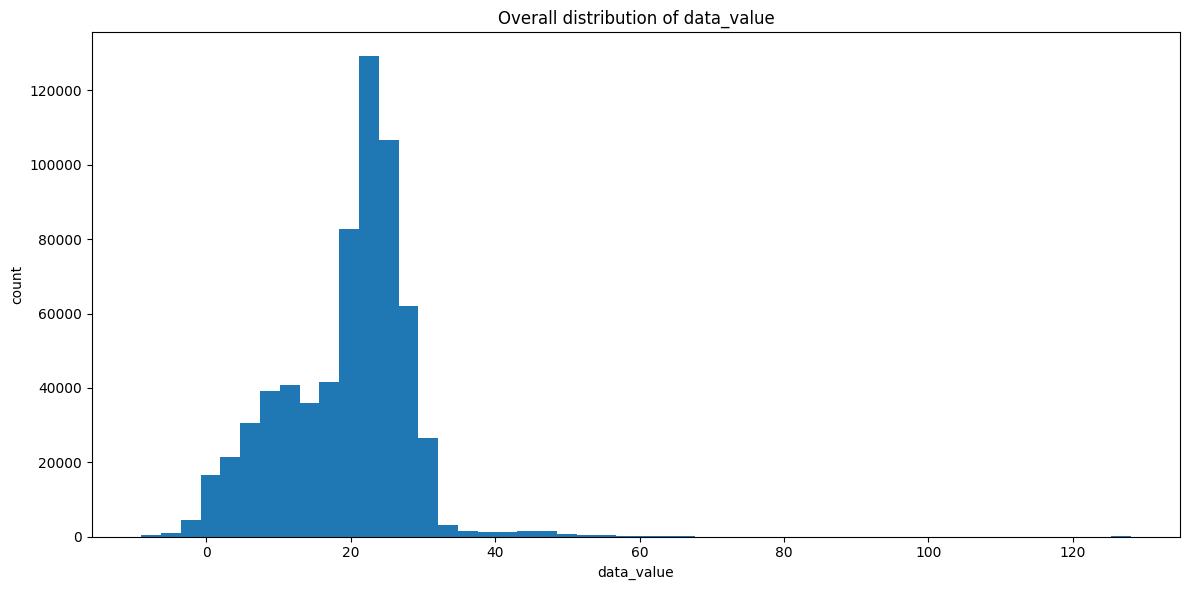

Saved: outputs/hist_overall_data_value.png


In [11]:
# Overall histogram
fig = plt.figure()
ax = plt.gca()
ax.hist(df['data_value'].dropna().values, bins=50)
ax.set_title('Overall distribution of data_value')
ax.set_xlabel('data_value')
ax.set_ylabel('count')
plt.tight_layout()
plt.savefig(OUT_DIR / 'hist_overall_data_value.png', dpi=150)
plt.show()
print('Saved:', OUT_DIR / 'hist_overall_data_value.png')


In [ ]:
# Boxplot by data_key (each key one figure)
for key, sub in df.groupby('data_key'):
    vals = sub['data_value'].dropna().values
    if len(vals) < 5:
        continue
    fig = plt.figure()
    ax = plt.gca()
    ax.boxplot(vals)
    ax.set_title(f'Boxplot: data_value for {key}')
    ax.set_xticklabels(['data_value'])
    ax.set_ylabel('value')
    plt.tight_layout()
    fname = OUT_DIR / f'box_{key}.png'
    plt.savefig(fname, dpi=150)
    plt.show()
    print('Saved:', fname)


## Coverage heatmap (daily completeness by location)

We compute daily completeness = `present_hours / 24` per `location` and day.
We then plot a heatmap for the **top 25 locations** by row count.

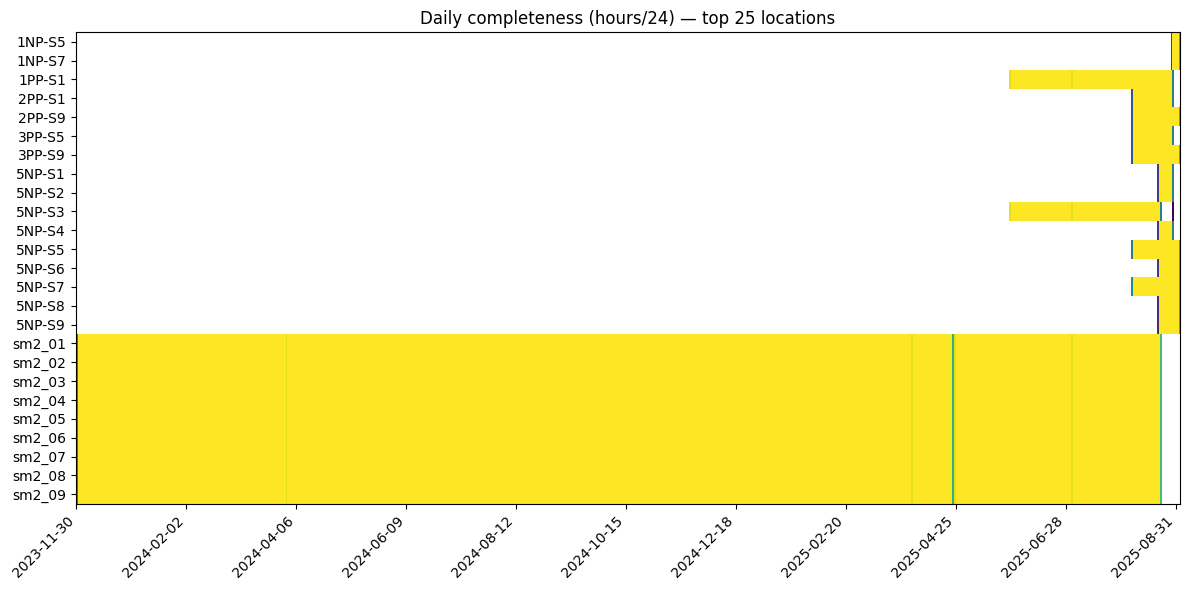

Saved: outputs/heatmap_daily_completeness_top25_locations.png


In [12]:
# Prepare daily completeness per location
df_day = df.copy()
df_day['day'] = df_day['time'].dt.floor('D')
present_hours = (df_day.groupby(['location','day'])['time']
                        .apply(lambda s: s.dt.floor('h').nunique())
                        .reset_index(name='hours_present'))
present_hours['completeness'] = present_hours['hours_present'] / 24.0

# Select top 25 locations by total rows
loc_counts = df['location'].value_counts().head(25).index.tolist()
heat = present_hours[present_hours['location'].isin(loc_counts)].copy()
pivot = heat.pivot(index='location', columns='day', values='completeness')
pivot = pivot.sort_index()

fig = plt.figure()
ax = plt.gca()
im = ax.imshow(pivot.values, aspect='auto', interpolation='nearest')
ax.set_title('Daily completeness (hours/24) — top 25 locations')
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xticks(range(0, len(pivot.columns), max(1, len(pivot.columns)//10)))
ax.set_xticklabels([str(d.date()) for i, d in enumerate(pivot.columns) if i % max(1, len(pivot.columns)//10) == 0], rotation=45, ha='right')
plt.tight_layout()
plt.savefig(OUT_DIR / 'heatmap_daily_completeness_top25_locations.png', dpi=150)
plt.show()
print('Saved:', OUT_DIR / 'heatmap_daily_completeness_top25_locations.png')


## Hour-of-day pattern (ThermoPro `temp_indoor`)

We plot mean temperature by **hour of day** across the entire history for ThermoPro `temp_indoor`.

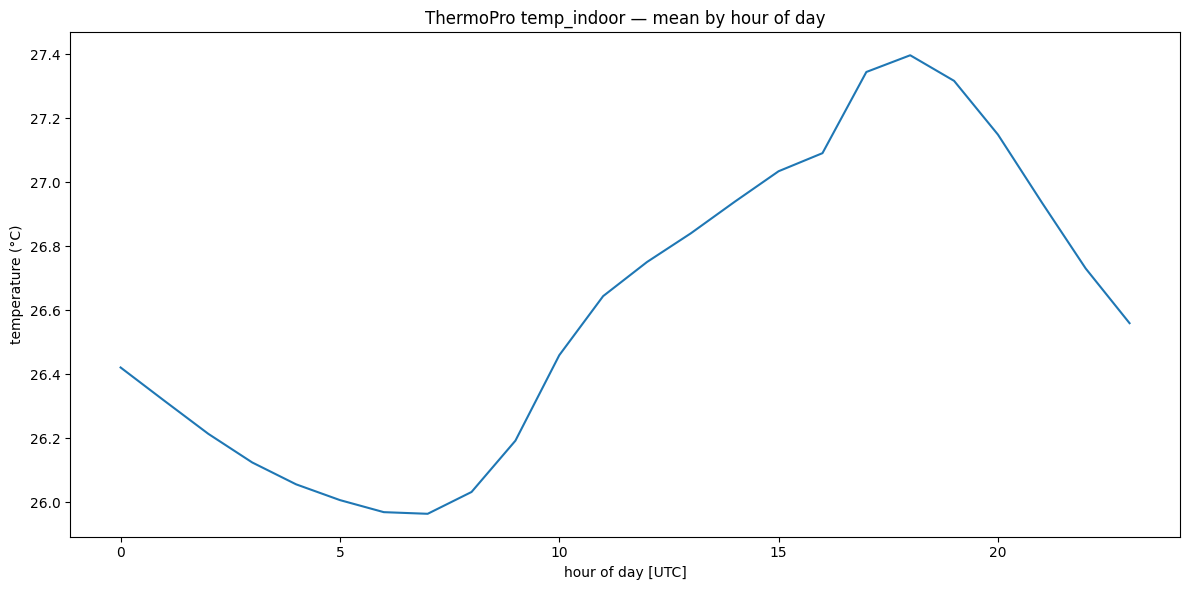

Saved: outputs/thermopro_temp_indoor_hour_of_day.png


In [13]:
thermo = df[(df['source']=='ThermoPro') & (df['data_key']=='temp_indoor')].copy()
if not thermo.empty:
    thermo['hod'] = thermo['time'].dt.hour
    hod_stats = thermo.groupby('hod')['data_value'].mean().reset_index()
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(hod_stats['hod'], hod_stats['data_value'])
    ax.set_title('ThermoPro temp_indoor — mean by hour of day')
    ax.set_xlabel('hour of day [UTC]')
    ax.set_ylabel('temperature (°C)')
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'thermopro_temp_indoor_hour_of_day.png', dpi=150)
    plt.show()
    print('Saved:', OUT_DIR / 'thermopro_temp_indoor_hour_of_day.png')
else:
    print('No ThermoPro temp_indoor data found.')


## Exports (QA-friendly summary tables)

We export the following CSVs in `outputs/`:
- `schema_overview.csv` — columns, dtypes, nulls, distincts, memory
- `top_values_*.csv` — top categorical values with frequencies
- `location_metadata.csv` — parsed Atrea/ThermoPro, floor, section
- `coverage_by_source.csv`, `coverage_by_source_data_key.csv`, `coverage_by_location.csv`
- `hourly_completeness_by_source_key_location.csv`
- `duplicates_keylevel.csv`, `duplicates_full.csv`
- `anomalies_humidity_range.csv`, `anomalies_temperature_range.csv`


## Next steps (how to adapt this template)

- Add **IQR-based outlier** detection per `(source,data_key,location)` if needed.
- Add **rolling QA rules** (e.g., monotonic constraints, rate-of-change thresholds).
- Integrate into **CI** (GitHub Actions) to run on every dataset refresh and publish artifacts.
- Parameterize the time window (e.g., last week/month) for focused reports.
- Enrich with **external weather** for cross-checks (e.g., ambient vs. indoor spreads).
